# Imports and helper functions

In [3]:
import pandas as pd
from swifter import swifter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import awswrangler as wr
import sweetviz as sv
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
import lightgbm as lgbm


def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n'))
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum()))

# def consult_table_athena(database, table):
#     wr.config.aws_profile = 'default'
#     wr.config.region = 'us-east-1'

#     query = f"SELECT * FROM {database}.{table}"

#     df = wr.athena.read_sql_query(query, database=database)

#     return df


def unique_values_columns(df):
    """
    Display unique values for each object (or string) column in a DataFrame.
    
    Parameters:
    - df (DataFrame): Input DataFrame
    
    Returns:
    - dict: A dictionary with column names as keys and unique values as lists.
    """
    
    # Filter out only object or string type columns
    object_cols = df.select_dtypes(include=['object']).columns
    
    # Get unique values for each object column
    unique_values = {col: df[col].unique().tolist() for col in object_cols}
    
    return unique_values

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Loading Data

In [9]:
# DATABASE = 'respiratory_db'
# TABLE = 'table_respiratory_train_data'
# df = consult_table_athena(DATABASE, TABLE)

# df.to_parquet('train.parquet', index=False)

# df = pd.read_csv('../data/raw/train.csv', low_memory=False)
# df.to_parquet('train.parquet', index=False)

In [4]:
df_raw = pd.read_parquet('../data/raw/train.parquet')

## Data description

In [5]:
df_raw.columns = df_raw.columns.str.lower()

In [41]:
df_raw['classi_fin'].value_counts().sort_index(ascending=True)

classi_fin
1     15628
2     31437
3      5935
4    380410
5    867570
Name: count, dtype: int64

In [7]:
df['fadiga'].unique()

array([ 2., nan,  1.,  9.])

In [6]:
class1 = df_raw[df_raw['classi_fin'] == 1]
class2 = df_raw[df_raw['classi_fin'] == 2]
class3 = df_raw[df_raw['classi_fin'] == 3]
class4 = df_raw[df_raw['classi_fin'] == 4].sample(31437)
class5 = df_raw[df_raw['classi_fin'] == 5].sample(31437)
df = pd.concat([class1, class2, class3, class4, class5], ignore_index=True)
del(df_raw)

In [9]:
data_description(df)

Variables:

sem_not         int64
sem_pri         int64
sg_uf_not      object
id_regiona     object
co_regiona    float64
id_municip     object
co_mun_not      int64
cs_sexo        object
nu_idade_n      int64
tp_idade        int64
cod_idade      object
cs_gestant      int64
cs_raca         int64
cs_escol_n    float64
sg_uf          object
cs_zona       float64
surto_sg      float64
nosocomial    float64
ave_suino     float64
febre         float64
tosse         float64
garganta      float64
dispneia      float64
desc_resp     float64
saturacao     float64
diarreia      float64
vomito        float64
outro_sin     float64
outro_des      object
puerpera      float64
fator_risc      int64
cardiopati    float64
hematologi    float64
sind_down     float64
hepatica      float64
asma          float64
diabetes      float64
neurologic    float64
pneumopati    float64
imunodepre    float64
renal         float64
obesidade     float64
obes_imc       object
out_morbi     float64
morb_desc      objec

In [5]:
df = reduce_mem_usage(df)

Mem. usage decreased to 26.19 Mb (61.0% reduction)


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sem_not,115874.0,23.585023,15.369219,1.0,11.0,22.0,36.0,52.0
sem_pri,115874.0,24.024622,15.726942,1.0,11.0,21.0,37.0,52.0
co_regiona,102583.0,NaN,NaN,1331.0,1342.0,1382.0,1519.0,6256.0
co_mun_not,115874.0,352287.508785,85783.835254,110001.0,311510.0,353800.0,410940.0,530010.0
nu_idade_n,115874.0,39.512721,31.342504,-9.0,5.0,42.0,68.0,117.0
tp_idade,115874.0,2.810225,0.421424,1.0,3.0,3.0,3.0,3.0
cs_gestant,115874.0,5.831196,0.805223,0.0,6.0,6.0,6.0,9.0
cs_raca,115874.0,3.560445,2.882355,1.0,1.0,4.0,4.0,9.0
cs_escol_n,75078.0,NaN,0.000000,0.0,2.0,5.0,9.0,9.0
cs_zona,115874.0,NaN,0.000000,1.0,1.0,1.0,1.0,9.0


### Data Cleaning / NA analysis / Outliers analysis

In [6]:
# Sexo have Male, F and I, lets take off the I value has there are just 188 lines.
df = df[df['cs_sexo'] != 'I']
df['cs_sexo'] = df['cs_sexo'].astype('category')

df = df.drop('delta_uti', axis=1)

# Negative ages are excluded
df = df[~df['nu_idade_n'] <= 0]

# Remove demographic categories

df = df.drop(
    [
    'sg_uf_not',
    'id_regiona',
    'co_regiona',
    'id_municip',
    'co_mun_not',
    'sg_uf',
    'cod_idade',
    'cs_escol_n'
    ], axis=1
)

In [9]:
df['perd_olft'].unique()

[2, 9, 1]
Categories (3, int8): [1, 2, 9]

In [7]:
float_cols = df.select_dtypes('float16').columns
df[float_cols] = df[float_cols].swifter.apply(
    lambda x: x.fillna(x.mode()[0])
)

df[float_cols] = df[float_cols].astype('int8')

int_cols = df.select_dtypes('int8').drop(['sem_not','sem_pri','nu_idade_n'], axis=1).columns
df[int_cols] = df[int_cols].astype('category')

predictors = df.drop('classi_fin', axis=1)
predictors = predictors.drop(predictors.select_dtypes('object'), axis=1)
response = df['classi_fin']

Pandas Apply:   0%|          | 0/44 [00:00<?, ?it/s]

### Feature selection to remove unimportant features

In [8]:
# #Excluding text columns
# predictors = df.drop('classi_fin', axis=1)
# predictors = predictors.drop(predictors.select_dtypes('object'), axis=1)
# response = df['classi_fin']

# X_train, X_val, y_train,y_val = train_test_split(
#     predictors, response, random_state=50, stratify=response
# )

# numerical_cols = predictors.select_dtypes(['int8']).columns.tolist()
# categorical_cols = predictors.select_dtypes(['category']).columns.tolist()

# categorical_imputer = ColumnTransformer(
#     [('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_cols)],
#     remainder='drop'
# )


# X_train_transformed = pd.DataFrame(
#     categorical_imputer.fit_transform(X_train),
#     columns=categorical_cols,
#     index=X_train.index
# )
# X_train_transformed = pd.concat([X_train_transformed,X_train[numerical_cols]],axis=1)
# X_train_transformed[categorical_cols] = X_train_transformed[categorical_cols].astype('category')

# X_val_transformed = pd.DataFrame(
#     categorical_imputer.transform(X_val),
#     columns=categorical_cols,
#     index=X_val.index
# )
# X_val_transformed = pd.concat([X_val_transformed,X_val[numerical_cols]],axis=1)
# X_val_transformed[categorical_cols] = X_val_transformed[categorical_cols].astype('category')

# categorical_transformer = Pipeline(
#     steps=[
#         ('encoder', CountFrequencyEncoder(encoding_method='frequency'))
#     ]
# )

# numerical_transformer = Pipeline(
#     steps=[
#         ('encoder', MinMaxScaler())
#     ]    
# )

# preprocessor = ColumnTransformer(
#     [
#         ('cat', categorical_transformer, categorical_cols),
#         ('num', numerical_transformer, numerical_cols)
#     ]   
# )

# X_train_transformed = pd.DataFrame(
#     preprocessor.fit_transform(X_train),
#     columns=predictors.columns,
#     index=X_train_transformed.index
# )

# X_val_transformed = pd.DataFrame(
#     preprocessor.transform(X_val),
#     columns=predictors.columns,
#     index=X_val_transformed.index
# )

# encoder = LabelEncoder()
# y_train= encoder.fit_transform(y_train)
# y_val = encoder.transform(y_val)

# classifiers = [
#     RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample'),
#     XGBClassifier(n_jobs=-1, random_state=42,objective='multi:softax', max_delta_step=1),
#     lgbm.LGBMClassifier(n_jobs=-1,  random_state=42, class_weight='balanced')
# ]

# for classifier in classifiers:
#     pipeline_1 = Pipeline(
#         steps= [
#         ('feature_selection', SelectFromModel(estimator=classifier))
#         ]
#     )
#     pipeline_2 = Pipeline(
#         steps= [
#         ('feature_selection', RFE(estimator=classifier))
#         ]
#     )
    
#     permutation_score = permutation_importance(
#         classifier.fit(X_train_transformed,y_train), X_val_transformed, y_val,
#         random_state=42, scoring='f1_weighted', n_repeats=10
#     )

#     importance = pd.DataFrame(
#         {'features':X_train_transformed.columns, 
#         'f1_weighted':permutation_score['importances_mean']}).sort_values(by='f1_weighted', ascending=False
#     )

#     print(
#         'model: {} \n features selected based on feature importance:{} \n\n'.format(pipeline_1['feature_selection'].estimator,
#         pipeline_1.fit(X_train_transformed,y_train).get_feature_names_out(input_features=None)) 
#         )
#     print(
#         'model: {} \n features_selected based on RFE:{} \n\n'.format(pipeline_2['feature_selection'].estimator,
#         pipeline_2.fit(X_train_transformed,y_train).get_feature_names_out(input_features=None))
#         )
#     print(importance, '\n\n\n')



#Features choosen to continue
feature_selected = [
    'id','sem_pri', 'cs_sexo', 'nu_idade_n', 'saturacao', 'antiviral',
    'tp_antivir', 'hospital', 'fadiga', 'dose_2_cov', 'dose_ref', 'classi_fin',
    'fnt_in_cov', 'uti','raiox_res', 'dor_abd', 'perd_olft', 'tomo_res',
    'cs_raca', 'cs_zona', 'ave_suino', 'fator_risc', 'pneumopati', 'imunodepre'
]

df = df[feature_selected]

# EDA

## Response analysis

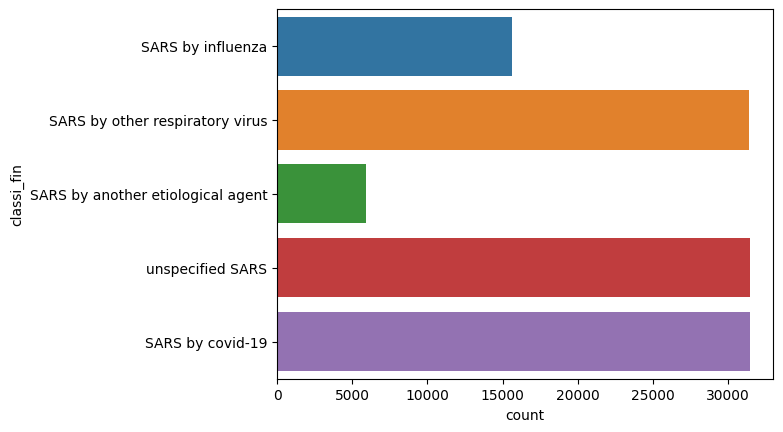

In [15]:
df_aux = df['classi_fin'].apply(
    lambda x: 'SARS by influenza' if x == 1
    else 'SARS by other respiratory virus' if x == 2
    else 'SARS by another etiological agent' if x == 3
    else 'unspecified SARS' if x == 4
    else 'SARS by covid-19'
)

sns.countplot(y=df_aux);

In [27]:
my_report = sv.analyze(df)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Data Dictionary

**SEM_PRI** - Semana Epidemiológica dos Primeiros Sintomas

**CS_SEXO** - Sexo do paciente

**NU_IDADE_N** - Idade ou 
       Idade informada
       pelo paciente
       quando não se sabe
       a data de nascimento
       Na falta desse dado é registrada a idade aparente
       
       Se digitado a data de nascimento a idade é calculada automaticamente pelo sistema considerando o intervalo entre a data de nascimento e a datraa dos primeiros sintomas
       
       idade deve ser <= 150

**SATURACAO** - Sinais e Sintomas/Saturação O2< 95%

    1-Sim
    2-Não
    9-Ignorado

**HOSPITAL** - Houve internação?

Caso o campo não seja igual a 1 – Sim o sistema emitirá um aviso indicando
que não atende a definição de caso.

    1-Sim
    2-Não
    9-Ignorado

**TOMO_RES** - Aspecto Tomografia

    1-Tipico covid-19
    2- Indeterminado covid-19
    3- Atípico covid-19
    4- Negativo para Pneumonia
    5- Outro
    6-Não realizado
    9-Ignorado

**FADIGA** - Sinais e Sintomas/Fadiga

    1-Sim
    2-Não
    9-Ignorado


**TP_ANTIVIR** - Qual antiviral?

Habilitado se campo 42(ANTIVIRAL) Usou antiviral para gripe? for igual a 1. 


    1- Oseltamivir
    2- Zanamivir
    3- Outro, especifique

**SUPORT_VEN** - Uso de suporte ventilatório?

suporte ventilatório no intuito de facilitar as trocas gasosas, reduzir a fadiga muscular, reduzir a dispnéia, melhorar a ventilação alveolar, aumentar a complacência pulmonar e a capacidade residual funcional, diminuir a morbidade e manter as vias aéreas abertas sem a necessidade de instituir uma via aérea 

    1-Sim, invasivo
    2-Sim, não invasivo
    3-Não
    9-Ignorado

**DOR_ABD** - Sinais e Sintomas/Dor abdominal

    1-Sim
    2-Não
    9-Ignorado

**PERD_OLFT** - Sinais e Sintomas/Perda do Olfato

    1-Sim
    2-Não
    9-Ignorado


**DOSE_1_COV** - Data 1ª dose da vacina COVID-19

Habilitado se campo 36(VACINA_COV) - Recebeu vacina COVID-19? for igual a 1.

Date
DD/MM/AAAA

**DOSE_2_COV** - Data 2ª dose da vacina COVID-19

Habilitado se campo 36(VACINA_COV) - Recebeu vacina COVID-19? for igual a 1.

Date
DD/MM/AAAA

**DOSE_REF** - Data da dose reforço da vacina COVID-19

Habilitado se campo 36(VACINA_COV) - Recebeu vacina COVID-19? for igual a 1.

Date
DD/MM/AAAA


**UTI** - Internado em UTI?

    1-Sim
    2-Não
    9-Ignorado

**RAIOX_RES** - Raio X de Tórax

    1-Normal
    2-Infiltrado intersticial
    3-Consolidação
    4-Misto
    5-Outro
    6-Não realizado
    9-Ignorado

**CLASSI_FIN** Classificação final do caso -- TARGET

    1-SRAG por influenza
    2-SRAG por outro vírus respiratório
    3-SRAG por outro agente etiologico qual
    4-SRAG não especificado
    5-SRAG por covid-19

## H1. The proportion of people who was classified with SARS by covid-19 and went to ICU was 15% higher than the proportion of people who was classified with SARS by influenza and went to ICU

,proportion,SARS type
0,0.323768,covid-19
1,0.240000,influenza


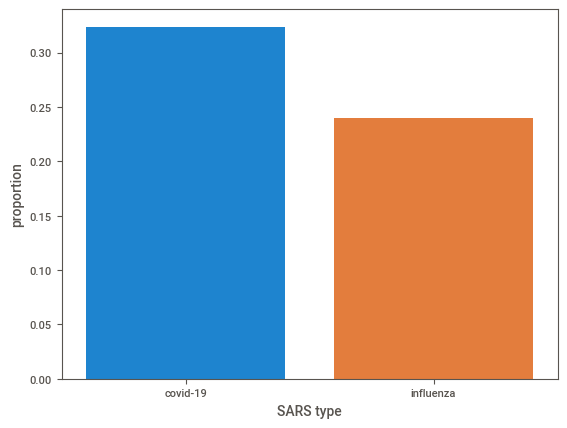

In [29]:
df_aux_covid = df[df['classi_fin'] == 5]
df_aux_influenza = df[df['classi_fin'] == 1]

proporp_covid_icu = df_aux_covid[df_aux_covid['uti'] == 1]['uti'].count() / len(df_aux_covid)
proporp_influenza_icu = df_aux_influenza[df_aux_influenza['uti'] == 1]['uti'].count() / len(df_aux_influenza)
df_aux = pd.DataFrame(
    {
        'proportion': [proporp_covid_icu, proporp_influenza_icu],
        'SARS type': ['covid-19','influenza']
    }
)
sns.barplot(x='SARS type', y='proportion', data=df_aux);
df_aux

True. The proportion is 35% higher.

## H2. The proportion of people who was classified with SARS by covid-19 and have lost the sense of smell was 20% higher than the proportion of who as classified with SARS by influenza and have lost the sense of smell

,proportion,SARS type
0,0.091464,covid-19
1,0.016384,influenza


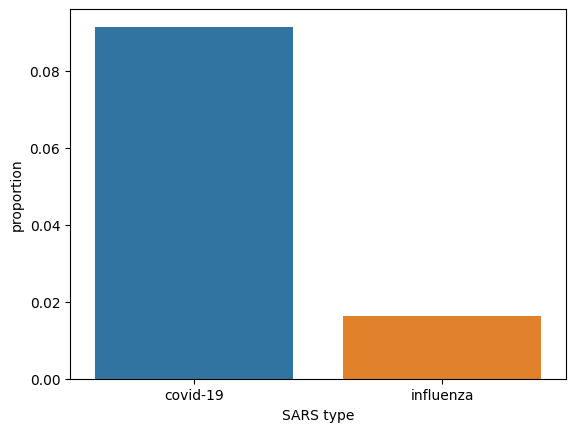

In [23]:
df_aux_covid = df[df['classi_fin'] == 5]
df_aux_influenza = df[df['classi_fin'] == 1]

proporp_covid_icu = df_aux_covid[df_aux_covid['perd_olft'] == 1]['perd_olft'].count() / len(df_aux_covid)
proporp_influenza_icu = df_aux_influenza[df_aux_influenza['perd_olft'] == 1]['perd_olft'].count() / len(df_aux_influenza)
df_aux = pd.DataFrame(
    {
        'proportion': [proporp_covid_icu, proporp_influenza_icu],
        'SARS type': ['covid-19','influenza']
    }
)
sns.barplot(x='SARS type', y='proportion', data=df_aux);
df_aux

True. In fact, the people who was classified with SARS by covid-19 and have lost the sense of smell is more than 4 times higher than the proportion of people who was classified with SARS by influenza and have lost the sense of smell.

## H3. The proportion of people who was classified with SARS by influenza and took oseltamivir  was 15% higher than the proportion of people who was classified with SARS by covid-19 and took oseltamivir

,proportion,SARS type
0,0.995451,covid-19
1,0.995008,influenza


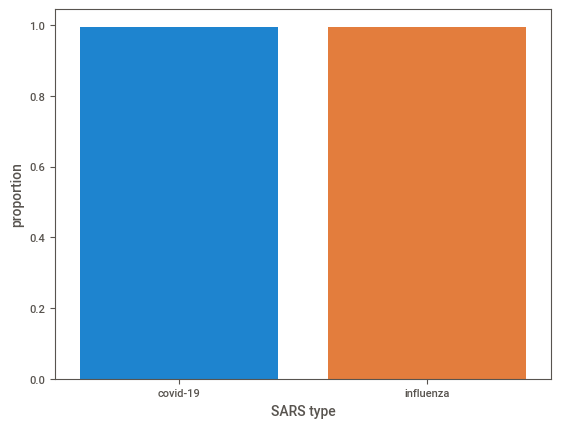

In [28]:
df_aux_covid = df[df['classi_fin'] == 5]
df_aux_influenza = df[df['classi_fin'] == 1]

proporp_covid_icu = df_aux_covid[df_aux_covid['tp_antivir'] == 1]['tp_antivir'].count() / len(df_aux_covid)
proporp_influenza_icu = df_aux_influenza[df_aux_influenza['tp_antivir'] == 1]['tp_antivir'].count() / len(df_aux_influenza)
df_aux = pd.DataFrame(
    {
        'proportion': [proporp_covid_icu, proporp_influenza_icu],
        'SARS type': ['covid-19','influenza']
    }
)
sns.barplot(x='SARS type', y='proportion', data=df_aux);
df_aux

False. Both has almost the same proportion of people who took the oseltamivir

## H4. The proportion of people who was classified with SARS by covid-19 and had fatigue symptoms was 10% higher than the proportion of people who was classified with SARS by influenza and had fatigue symptoms

,proportion,SARS type
0,0.256641,covid-19
1,0.178304,influenza


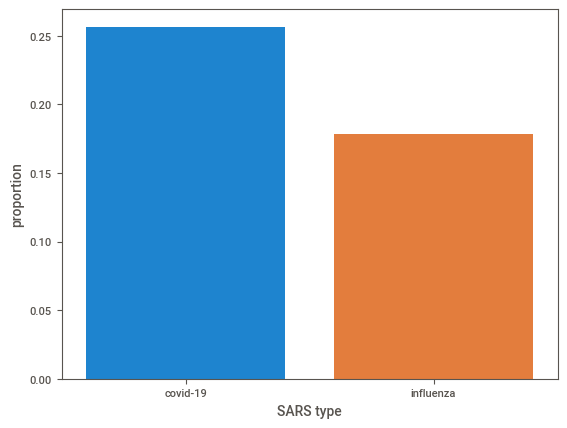

In [31]:
df_aux_covid = df[df['classi_fin'] == 5]
df_aux_influenza = df[df['classi_fin'] == 1]

proporp_covid_icu = df_aux_covid[df_aux_covid['fadiga'] == 1]['fadiga'].count() / len(df_aux_covid)
proporp_influenza_icu = df_aux_influenza[df_aux_influenza['fadiga'] == 1]['fadiga'].count() / len(df_aux_influenza)
df_aux = pd.DataFrame(
    {
        'proportion': [proporp_covid_icu, proporp_influenza_icu],
        'SARS type': ['covid-19','influenza']
    }
)
sns.barplot(x='SARS type', y='proportion', data=df_aux);
df_aux

True. The proportion if 44% higher

## H5. The proportion of people who was classified with SARS by covid-19 and had abdominal pain was 25% higher than the proportion of people who was classified with SARS by influenza and had abdominal pain

,proportion,SARS type
0,0.061241,covid-19
1,0.047168,influenza


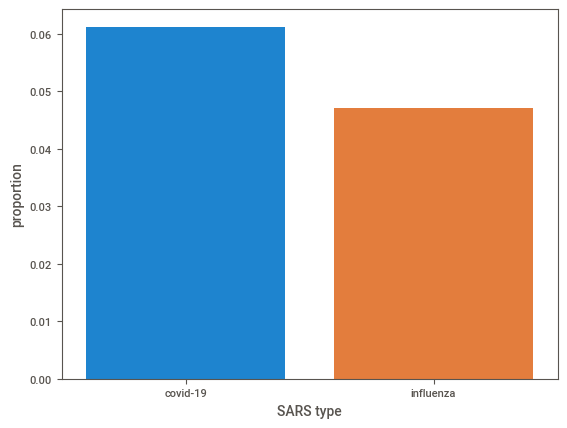

In [32]:
df_aux_covid = df[df['classi_fin'] == 5]
df_aux_influenza = df[df['classi_fin'] == 1]

proporp_covid_icu = df_aux_covid[df_aux_covid['dor_abd'] == 1]['dor_abd'].count() / len(df_aux_covid)
proporp_influenza_icu = df_aux_influenza[df_aux_influenza['dor_abd'] == 1]['dor_abd'].count() / len(df_aux_influenza)
df_aux = pd.DataFrame(
    {
        'proportion': [proporp_covid_icu, proporp_influenza_icu],
        'SARS type': ['covid-19','influenza']
    }
)
sns.barplot(x='SARS type', y='proportion', data=df_aux);
df_aux

True. The proportion is about 30% higher

# Data preparation and feature selection

NameError: name 'df' is not defined

In [9]:
#Replace 9 values to mode of each column
df_category = (
    df.select_dtypes(include='category')
    .drop('cs_sexo',axis=1)
    .columns.to_list()
)
column_modes = df[df_category].mode().iloc[0]
df[df_category] = df[df_category].apply(
    lambda col: col.replace(9, column_modes[col.name])
)

# Create new bucket for processed data

In [10]:
bucket = 'traintest-respiratory-classification'
prefix1= 'train'
prefix2 = 'test'

In [ ]:
predictors = df.drop('classi_fin', axis=1)
predictors = predictors.drop(predictors.select_dtypes('object'), axis=1)
response = df['classi_fin']

X_train, X_test, y_train,y_test = train_test_split(
    predictors, response, random_state=50, 
    stratify=response, test_size=0.2
)

#Send to S3
train_data = pd.concat([X_train,y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_parquet('train.parquet', index=False, header=False)
test_data.to_parquet('test.parquet', index=False, header=False)

In [18]:


numerical_cols = predictors.select_dtypes(['int8']).columns.tolist()
categorical_cols = predictors.select_dtypes(['category']).columns.tolist()


categorical_transformer = Pipeline(
    steps=[
        ('encoder', CountFrequencyEncoder(encoding_method='frequency'))
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ('encoder', MinMaxScaler())
    ]    
)

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]   
)

X_train = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index
)

X_val = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
    index=X_val.index
)

encoder = LabelEncoder()
y_train= encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

In [19]:
classifiers = [
    RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample'),
    XGBClassifier(n_jobs=-1, random_state=42,objective='multi:softax', max_delta_step=1),
    lgbm.LGBMClassifier(n_jobs=-1,  random_state=42, class_weight='balanced')
]

for classifier in classifiers:
    pipeline_1 = Pipeline(
        steps= [
        ('feature_selection', SelectFromModel(estimator=classifier))
        ]
    )
    pipeline_2 = Pipeline(
        steps= [
        ('feature_selection', RFE(estimator=classifier))
        ]
    )
    
    permutation_score = permutation_importance(
        classifier.fit(X_train,y_train), X_val, y_val,
        random_state=42, scoring='f1_weighted', n_repeats=10
    )

    importance = pd.DataFrame(
        {'features':X_train.columns, 
        'f1_weighted':permutation_score['importances_mean']}).sort_values(by='f1_weighted', ascending=False
    )

    print(
        'model: {} \n features selected based on feature importance:{} \n\n'.format(pipeline_1['feature_selection'].estimator,
        pipeline_1.fit(X_train,y_train).get_feature_names_out(input_features=None)) 
        )
    print(
        'model: {} \n features_selected based on RFE:{} \n\n'.format(pipeline_2['feature_selection'].estimator,
        pipeline_2.fit(X_train,y_train).get_feature_names_out(input_features=None))
        )
    print(importance, '\n\n\n')


model: RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42) 
 features selected based on feature importance:['cat__raiox_res' 'cat__tomo_res' 'num__sem_pri' 'num__nu_idade_n'] 


model: RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42) 
 features_selected based on RFE:['cat__cs_sexo' 'cat__saturacao' 'cat__fadiga' 'cat__dose_2_cov'
 'cat__uti' 'cat__raiox_res' 'cat__tomo_res' 'cat__cs_raca'
 'cat__fator_risc' 'num__sem_pri' 'num__nu_idade_n'] 


           features  f1_weighted
21  num__nu_idade_n     0.185661
20     num__sem_pri     0.090728
13    cat__tomo_res     0.035245
2    cat__antiviral     0.010277
10   cat__raiox_res     0.009503
6   cat__dose_2_cov     0.008713
14     cat__cs_raca     0.006436
9          cat__uti     0.005157
8   cat__fnt_in_cov     0.004452
1    cat__saturacao     0.002631
4     cat__hospital     0.002617
15     cat__cs_zona     0.002197
5     

In [42]:
# Machine learning modelling